In [25]:
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.model_selection import train_test_split
import random

df = pd.read_csv('data/iris.csv')
df['SepalArea']=df['SepalLength']*df['SepalWidth']
df['PetalArea']=df['PetalLength']*df['PetalWidth']
speciesmap = {'setosa':0,'versicolor':1,'virginica':2}
df['species']=df['species'].map(speciesmap)

# we make a static list of dataframe indexes for test and train so that we are
# always using the "same" data points for test and train since there is inheritance from
# one epoch to the next.
test_size = 0.5
test_indexes=sorted(df.sample(int(test_size*(df.index.shape[0]))).index)
train_indexes = [i for i in df.index if i not in test_indexes]
y = np.array(df['species'])
X = np.array(df[[c for c in df.columns if c not in ['species','SepalArea','PetalArea']]])
X_train=X[train_indexes]
y_train=y[train_indexes]
X_test=X[test_indexes]
y_test=y[test_indexes]
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
preds = clf.predict(X_test)


In [26]:
def f_confusion_map(actual,predicted,n):
    if (actual==predicted):
        return(int(actual))
    else:
        return(int(predicted+n))

df_test = df.loc[test_indexes].copy(deep=True)
df_test['prediction']=preds
df_test['confusion_class']=df_test.apply(lambda x: f_confusion_map(x.species, x.prediction, len(speciesmap)), axis=1)    

<AxesSubplot:xlabel='SepalArea', ylabel='PetalArea'>

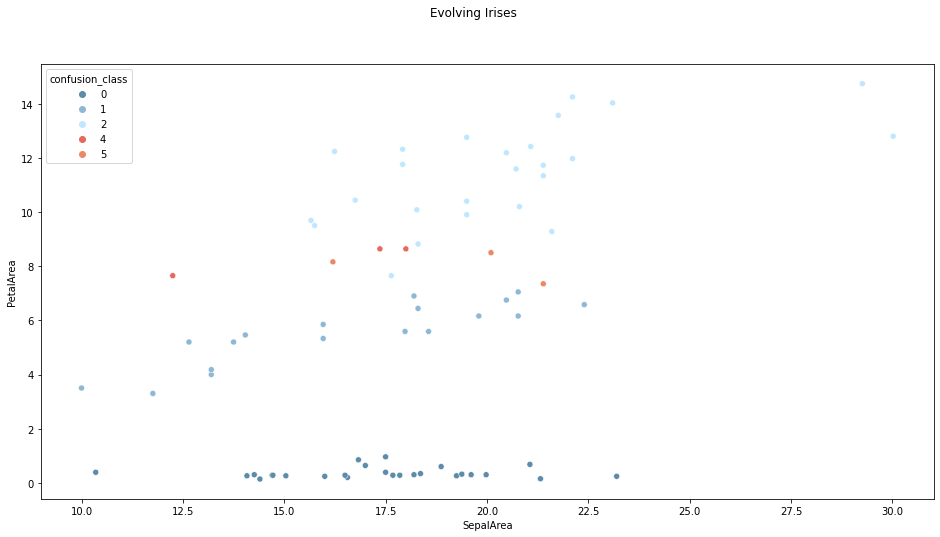

In [27]:
subplots_y,subplots_x = 1,1
fig, axes = plt.subplots(subplots_y, subplots_x, sharex=True, figsize=(16,8))
fig.suptitle('Evolving Irises')
subx,suby=(1,1)
palette ={0:"#5d8ba9",1:"#8eb8d3",2:"#c1e7ff",3:"#de425b",4:"#e7685c",5:"#ec8965"}
sns.scatterplot(data = df_test, x = "SepalArea", y = "PetalArea", hue = "confusion_class",  palette=palette)



Woot start evolving the data

In [28]:
MIN_SEPAL_AREA = max(0,0.8*min(df['SepalArea']))
MIN_PETAL_AREA = max(0,0.8*min(df['PetalArea']))
MAX_SEPAL_AREA = (1.20*max(df['SepalArea']))
MAX_PETAL_AREA = (1.20*max(df['PetalArea']))
print(f'MIN_SEPAL_AREA:{MIN_SEPAL_AREA}\nMIN_PETAL_AREA:{MIN_PETAL_AREA}\nMAX_SEPAL_AREA:{MAX_SEPAL_AREA}\nMAX_PETAL_AREA:{MAX_PETAL_AREA}\n')

MIN_SEPAL_AREA:8.0
MIN_PETAL_AREA:0.08800000000000002
MAX_SEPAL_AREA:36.024
MAX_PETAL_AREA:19.043999999999997



In [29]:
def smote_interpolate(df,include=None):
    '''smote_interpolate creates a new dataframe by pairing existing 
    data points (randomly selecting an offset) and then randomly choosing a linear combination 
    of two data points in n-space
    
    include: list of columns that you want to Smote interpolate
    '''
    if include==None:
        include=df.columns
    df_length = df.shape[0]
    pair_offset = min((df_length-1),int(1+((df_length-1)*np.random.uniform())))
    df_rolled = df.reindex(np.roll(df.index, pair_offset)).set_index(df.index)
    smote_scaler=1.-0.1*np.random.uniform(size=df_length)
    df_smote=df[include].multiply(smote_scaler,axis=0)+df_rolled[include].multiply(1-smote_scaler,axis=0)

    return df.drop(include,axis=1).merge(df_smote,left_index=True,right_index=True)

In [30]:
def rand_move(df_input):
    spp = df_input['species'].unique()
    df = pd.DataFrame()
    for species in spp:
        df_species = df_input[df_input['species']==species].copy(deep=True)
        move_mean_Sepal=np.random.normal(0.,0.8*df_species['SepalArea'].std(),size=1)
        move_mean_Petal=np.random.normal(0.,0.8*df_species['PetalArea'].std(),size=1)
#         r_vector_SepalArea = np.random.normal(df_species['SepalArea'].mean()+move_mean_Sepal,1.0*df_species['SepalArea'].std(),size=df_species.shape[0]).clip(MIN_SEPAL_AREA,MAX_SEPAL_AREA)/df_species['SepalArea'].mean()
#         r_vector_PetalArea = np.random.normal(df_species['PetalArea'].mean()+move_mean_Petal,1.0*df_species['PetalArea'].std(),size=df_species.shape[0]).clip(MIN_PETAL_AREA,MAX_PETAL_AREA)/df_species['PetalArea'].mean()
#         df_species['SepalArea'] = np.random.normal(df_species['SepalArea'].mean()+move_mean_Sepal,1.0*df_species['SepalArea'].std(),size=df_species.shape[0]).clip(MIN_SEPAL_AREA,MAX_SEPAL_AREA)
#         df_species['PetalArea'] = np.random.normal(df_species['PetalArea'].mean()+move_mean_Petal,1.0*df_species['PetalArea'].std(),size=df_species.shape[0]).clip(MIN_PETAL_AREA,MAX_PETAL_AREA)

        df_species['SepalArea'] = (df_species['SepalArea']+np.random.normal(move_mean_Sepal,0.4*df_species['SepalArea'].std(),size=df_species.shape[0])).clip(MIN_SEPAL_AREA,MAX_SEPAL_AREA)
        df_species['PetalArea'] = (df_species['PetalArea']+np.random.normal(move_mean_Petal,0.4*df_species['PetalArea'].std(),size=df_species.shape[0])).clip(MIN_PETAL_AREA,MAX_PETAL_AREA)

#         print(f'Min/Max SepalArea:{np.min(r_vector_SepalArea),np.max(r_vector_SepalArea)}')
#         print(f'Min/Max PetalArea:{np.min(r_vector_PetalArea),np.max(r_vector_PetalArea)}')
#         df_species['SepalLength']=df_species['SepalLength'].multiply(np.sqrt(r_vector_SepalArea),axis=0,)
#         df_species['SepalWidth']=df_species['SepalWidth'].multiply(np.sqrt(r_vector_SepalArea),axis=0,)
#         df_species['PetalLength']=df_species['PetalLength'].multiply(np.sqrt(r_vector_PetalArea),axis=0,)
#         df_species['PetalWidth']=df_species['PetalWidth'].multiply(np.sqrt(r_vector_PetalArea),axis=0,)
        df_species['SepalLength']=np.sqrt(df_species['SepalLength']*df_species['SepalArea']/df_species['SepalWidth'])
        df_species['SepalWidth']=np.sqrt(df_species['SepalWidth']*df_species['SepalArea']/df_species['SepalLength'])
        df_species['PetalLength']=np.sqrt(df_species['PetalLength']*df_species['PetalArea']/df_species['PetalWidth'])
        df_species['PetalWidth']=np.sqrt(df_species['PetalWidth']*df_species['PetalArea']/df_species['PetalLength'])
        df_species = smote_interpolate(df_species,include=['SepalLength','SepalWidth','PetalLength','PetalWidth'])
        df = pd.concat([df, df_species])
        
    df['SepalArea']=df['SepalLength']*df['SepalWidth']
    df['PetalArea']=df['PetalLength']*df['PetalWidth']
    return df
    

In [31]:
y = np.array(df['species'])
X = np.array(df[[c for c in df.columns if c not in ['species','SepalArea','PetalArea']]])
X_train=X[train_indexes]
y_train=y[train_indexes]
X_test=X[test_indexes]
y_test=y[test_indexes]
# clf = GradientBoostingClassifier()
# clf.fit(X_train, y_train)
# clf.score(X_test, y_test)
preds = clf.predict(X_test)
df_test = df.loc[test_indexes].copy(deep=True)
df_test['prediction']=preds
df_test['confusion_class']=df_test.apply(lambda x: f_confusion_map(x.species, x.prediction, len(speciesmap)), axis=1)    



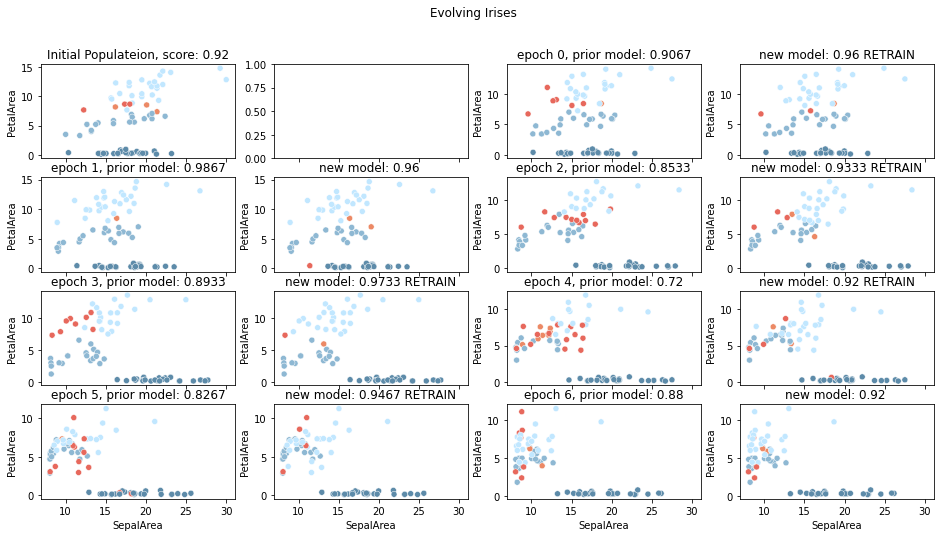

In [32]:
N_epochs = 7
subplots_x = 4 # must be even
subplots_y = 1+((N_epochs)//(subplots_x//2))
fig, axes = plt.subplots(subplots_y, subplots_x, sharex=True, figsize=(16,8))
fig.suptitle('Evolving Irises')
prior_score = clf.score(X_test, y_test)
axes[0,0].set_title(f'Initial Populateion, score: {np.round(prior_score,4)}')

sns.scatterplot(ax=axes[0,0], data = df_test, x = "SepalArea", y = "PetalArea", hue = "confusion_class",  palette=palette).get_legend().remove()
#plt.legend([],[], frameon=False)
# ax[0].get_legend().remove()
#sns.scatterplot(ax=axes[0,0],data = df, x = "SepalArea", y = "PetalArea", hue = "species")

for epoch in range(N_epochs):
#for i in range(1,subplots_y*subplots_x):
    df = rand_move(df)
    y = np.array(df['species'])
    X = np.array(df[[c for c in df.columns if c not in ['species','SepalArea','PetalArea']]])
    X_train=X[train_indexes]
    y_train=y[train_indexes]
    X_test=X[test_indexes]
    y_test=y[test_indexes]

    prior_score = clf.score(X_test, y_test)
    preds = clf.predict(X_test)
    df_test = df.loc[test_indexes].copy(deep=True)
    df_test['prediction']=preds
    df_test['confusion_class']=df_test.apply(lambda x: f_confusion_map(x.species, x.prediction, len(speciesmap)), axis=1)    

    suby = 2*(epoch+1)//subplots_x
    subx = 2*(epoch+1)%subplots_x # this is the subplot of the left (old model) plot; add +1 for the new model
    axes[suby,subx].set_title(f'epoch {epoch}, prior model: {np.round(prior_score,4)}')
    sns.scatterplot(ax=axes[suby,subx], data = df_test, x = "SepalArea", y = "PetalArea", hue = "confusion_class",  palette=palette).get_legend().remove()
    clf_new = GradientBoostingClassifier()
    clf_new.fit(X_train, y_train)
    new_score = clf_new.score(X_test, y_test)
    new_preds = clf_new.predict(X_test)
    df_test['new_prediction']=new_preds
    df_test['new_confusion_class']=df_test.apply(lambda x: f_confusion_map(x.species, x.new_prediction, len(speciesmap)), axis=1)    
    retrain = ''
    if new_score>prior_score+0.05:
        clf = clf_new
        retrain = 'RETRAIN'
    axes[suby,subx+1].set_title(f'new model: {np.round(new_score,4)} {retrain}')
    sns.scatterplot(ax=axes[suby,subx+1], data = df_test, x = "SepalArea", y = "PetalArea", hue = "new_confusion_class",  palette=palette).get_legend().remove()





